In [1]:
from IPython.core.display import HTML
css_file = './notebook.css'
HTML(open(css_file, "r").read())

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import patsy
import scipy.optimize as opt

prop = mpl.font_manager.FontProperties(fname='/Users/a-makabi/Library/Fonts/Ricty-Regular.ttf')
mpl.rcParams['font.family'] = prop.get_name()

plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'

# 7章 一般化線形混合モデル (GLMM)

実験・調査で得られたカウントデータのばらつきは，ポアソン分布や二項分布だけではうまく説明出来ない

- 「説明変数以外は全部均質」といった条件は，現実の生物では満たされない
- 説明変数が同じであるなら平均も同じというGLMの仮定が成立しない
  - GLMでは，データにばらつきをもたらす「個体間の差異」を定量化出来ない

この章の内容

→ これまで登場したGLMでは現実のデータ解析には応用出来ない  
→ 「人間が測定できない・測定しなかった個体差」を組み込んだGLMである， __一般化線形混合モデル (Generalized linear mixed model, GLMM)__ を考えよう．GLMMは，複数の確率分布を部品とする統計モデルである

## 7.1 例題：GLMでは説明できないカウントデータ

架空植物の各個体から8個の種子をとってきて，そのうちいくつが生存しているかを調査 (6章と同様)  
生存種子数が葉数とともにどのように増大するかを解明するのが目的  
今回は100個体を調査対象とした

- x: 葉数 ( $2\leq x_i\leq 6$ となるように葉数を調整．葉数ごとの調査個体数は20)
- y: 生存していた種子数 (全種子が生存していた場合: $y_i=8$，全種子が全滅していた場合: $y_i=0$)
- N: 調査種子数 (今回の場合，全部8)

In [3]:
# data download: http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
df = pd.read_csv('data/data.csv', index_col='id')
df.head()

,N,y,x
id,,,
1,8,0,2
2,8,1,2
3,8,2,2
4,8,4,2
5,8,1,2


In [4]:
# 葉数が2~6の5種類で，それぞれ20個体調査しているので，全調査数は5*20=100
df.x.size

100

In [5]:
def yi(xi, beta1, beta2):
    # 生存種子数 yi = xi の調査種子数 × xi の生存確率
    return 8 * qi(xi, beta1, beta2)

def qi(xi, beta1, beta2):
    # xi の生存確率の計算
    return 1.0 / (1 + np.exp(-1 * (beta1 + xi * beta2)))

def draw_heatmap(data):
    fig, ax = plt.subplots()
    ax.pcolor(data, cmap=plt.cm.Blues)

    plt.yticks(np.arange(0.5, len(data.index), 1), data.index)
    plt.xticks(np.arange(0.5, len(data.columns), 1), data.columns)
    
    ax.set_xlabel('num of leaves: xi')
    ax.set_ylabel('num of alived seeds: yi')

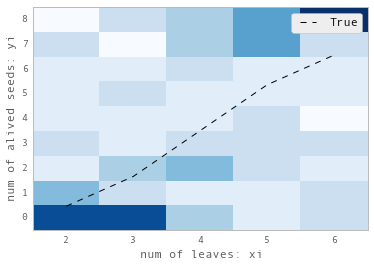

In [6]:
seed_df = pd.DataFrame(df.groupby([df.x, df.y]).size(), columns=['count']).reset_index()
seed_df_pivot = pd.pivot_table(seed_df, values='count', index=['y'], columns=['x']).fillna(0)

# 生存種子数数のヒートマップ
draw_heatmap(seed_df_pivot)

# 真の生存確率 (β1=-4, β2=1) から求められた生存種子数 (破線)
plt.plot([xi - seed_df.x.min() + 0.5 for xi in seed_df.x.unique()], [yi(xi, -4, 1) for xi in seed_df.x.unique()], 'k--', label='True')

plt.legend()
plt.show()

観測された生存種子数が $y_i$ である確率が，生存確率 $q_i$ の二項分布に従うとする

$$p(y_i | \beta_1,\beta_2) = q_i^{y_i}(1-q_i)^{8-y_i}$$

$$$$

二項分布の定義については，p.118を参照  
上限のあるカウントデータを扱う際に利用する確率分布である

個体 $i$ での種子の生存確率 $q_i$ が葉数 $x_i$ に依存するようにモデルを考える  
確率分布が二項分布なので，ここではリンク関数にロジットリンク関数を考える (生存確率 $q_i$ が線形予測子のロジスティック関数であると仮定)

$${\rm logit}(q_i)=\log\frac{q_i}{1-q_i}=\beta_1+\beta_2x_i$$

$$\left(q_i={\rm logistic}(\beta_1+\beta_2x_i)=\frac{1}{1+\exp(-(\beta_1+\beta_2x_i))}\right)$$

 全個体の対数尤度が最大になるような切片 $\beta_1$ と葉数 $x_i$ の傾き $\beta_2$ を探しだすのが，このモデルにおける最尤推定である
 
$$\log L=\sum_i\log p(y_i|\beta_1,\beta_2)$$

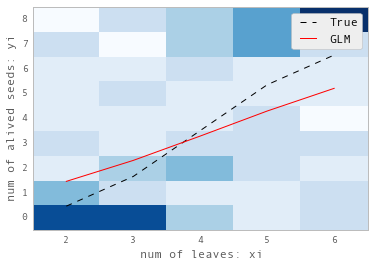

In [7]:
# 生存種子数数のヒートマップ
draw_heatmap(seed_df_pivot)

# 真の生存確率 (β1=-4, β2=1) から求められた生存種子数 (破線)
plt.plot([xi - seed_df.x.min() + 0.5 for xi in seed_df.x.unique()], [yi(xi, -4, 1) for xi in seed_df.x.unique()], 'k--', label='True')

# GLMによって求められた推定値
plt.plot([xi - seed_df.x.min() + 0.5 for xi in seed_df.x.unique()], [yi(xi, -2.15, 0.51) for xi in seed_df.x.unique()], color='red', label='GLM')

plt.legend()
plt.show()

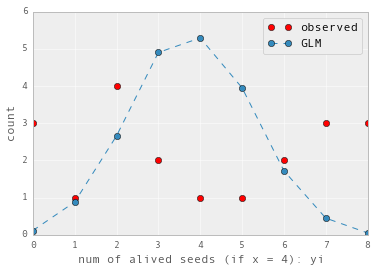

In [8]:
df4 = pd.DataFrame(df[df.x == 4].y.value_counts().reset_index())
df4.columns = ['yi', 'num_y']
plt.plot(df4.yi, df4.num_y, 'o', color='red', label='observed')

pred_df4 = pd.DataFrame(pd.DataFrame([np.random.binomial(n=8, p=qi(4, -2.15, 0.51)) for i in range(10000)], columns=['x']).x.value_counts().reset_index())
pred_df4.columns = ['yi', 'num_y']
pred_df4 = pred_df4.sort(columns=['yi'])
plt.plot(pred_df4.yi, [i * 0.002 for i in pred_df4.num_y], 'o--', label='GLM')

plt.legend()
plt.ylabel('count')
plt.xlabel('num of alived seeds (if x = 4): yi')

## 7.2 過分散と個体差
二項分布で期待されるよりも大きなばらつきを過分散 (または過大分散，overdispersion) という

### 7.2.1 過分散：ばらつきが大きすぎる
葉数 $x_i=4$ の個体の生存種子数のデータが，どのように「二項分布にあっていない」のか調査する

In [9]:
df4.sort(columns=['yi']).T

,3,8,0,5,7,6,4,2,1
yi,0,1,2,3,4,5,6,7,8
num_y,3,1,4,2,1,1,2,3,3


In [10]:
mean = df[df.x == 4].y.mean()
var = df[df.x == 4].y.var()
N = df.N.values[0]

"実際の平均: {0}, 実際の分散: {1} (生存確率の平均: {2})".format(mean, var, mean / N)

'実際の平均: 4.05, 実際の分散: 8.36578947368421 (生存確率の平均: 0.50625)'

In [11]:
# 生存種子数 yi が二項分布にしたがうと仮定した場合の分散
"予測モデルの分散: {0}".format(N * (mean / N) * (1 - mean / N))

'予測モデルの分散: 1.9996875'

実際の分散と4倍近くのずれがある  
→ このデータは二項分布とよぶには「ばらつきが大きすぎる」

### 7.2.2 観測されていない個体差がもたらす過分散
単純な二項分布モデルからのずれの原因のひとつとして，観測されていない個体差があげられる  
個体差を無視すると，観測された現象のパターンをうまく説明できない

### 7.2.3 観測されていない個体差とは何か？
データとしては定量化も識別化もされていないけれど，「各個体 (観測の単位) の何かに起因しているようにみえる差」のこと．少なくとも2種類の要因が考えられる

- 生物的 (biotic): 個体の遺伝子 等
- 非生物的 (abiotic): 局所的な栄養塩類量や水環境 等 --> __場所差__ または __ブロック差__

架空植物に影響を与えている要因すべてを定量・特定することは不可能なので，このような個体差や場所差を原因不明のまま，これらのおよぼす影響をうまくとりこんだ統計モデルが必要になる

## 7.3 一般化線形混合モデル
一般化線形混合モデル (GLMM) は，個体差や場所差の効果をGLMにくみこんだ統計モデルである

### 7.3.1 個体差をあらわすパラメータの追加
生存確率 $q_i$ をあらわす式に，個体 $i$ の個体差をあらわすパラメータ $r_i\ (-\infty〜\infty )$ を追加する

$${\rm logit}(q_i)=\beta_1+\beta_2x_i+r_i$$

同じ葉数 $x_i$ であっても，個体差 $r_i>0$ となった場合には「平均的な個体 ($r_i=0$) 」より生存確率が高くなり，$r_i<0$ では低くなる

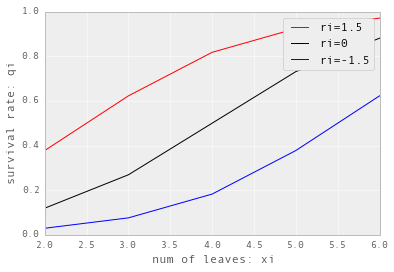

In [12]:
def new_qi(xi, beta1, beta2, ri):
    # xi の生存確率の計算
    return 1.0 / (1 + np.exp(-1 * (beta1 + xi * beta2 + ri)))

# ri = 1.5 (ri > 0) ※赤
plt.plot([xi for xi in seed_df.x.unique()], [new_qi(xi, -4, 1, 1.5) for xi in seed_df.x.unique()], 'r', label='ri=1.5')
plt.ylim(ymin=0.0, ymax=1.0)

# ri = 0 ※黒
plt.plot([xi for xi in seed_df.x.unique()], [new_qi(xi, -4, 1, 0) for xi in seed_df.x.unique()], 'k', label='ri=0')
plt.ylim(ymin=0.0, ymax=1.0)

# ri = 1.5 (ri < 0) ※青
plt.plot([xi for xi in seed_df.x.unique()], [new_qi(xi, -4, 1, -1.5) for xi in seed_df.x.unique()], 'b', label='ri=-1.5')
plt.ylim(ymin=0.0, ymax=1.0)

plt.legend()
plt.xlabel('num of leaves: xi')
plt.ylabel('survival rate: qi')

### 7.3.2 個体差のばらつきをあらわす確率分布
GLMMの特徴は，個体差のばらつきをあらわすパラメータが何かの確率分布に従っていると仮定し，データにもとづいてその確率分布のパラメータまで推定できるところである  
ここでは，個体差 $r_i$ は平均ゼロで標準偏差 $s$ の正規分布に従うと仮定する  
(※正規分布を仮定すると便利であるだけであって根拠はない)

- 個体差のばらつきが小さい --> $s$ が小さい
- 個体差のばらつきが大きい --> $s$ が大きい

### 7.3.3 線形予測子の構成要素：固定効果とランダム効果
線形予測子の構成要素として，固定効果とランダム効果をもつ統計モデルを混合 (mixed) モデルと呼ぶ  
たとえば今回のモデルの場合，固定効果 / ランダム効果は以下の通りとなる

- 固定効果 (fixed effects): $\beta_1$, $\beta_2x_i$
- ランダム効果 (random effects): $r_i$

## 7.4 一般化線形混合モデルの最尤推定
個体差 $r_i$ は最尤推定できないが，切片 $\beta_1$ と傾き $\beta_2$ を最尤推定したい  
一つの方法は，個体ごとの尤度 $L_i$ の式の中で， $r_i$ を積分することである

$$L_i=\int_{-\infty}^{\infty}p(y_i|\beta_1,\beta_2,r_i)p(r_i|s)dr_i$$

これは，いろいろな $r_i$ の値における尤度を評価し，その期待値を算出することに相当する

In [13]:
# β=0 と置いているため，以下の通り書き換えられる
qi = lambda ri: 1. / (1 + np.exp(-1 * ri))
pr = lambda ri, s: 1. / np.sqrt(2 * np.pi * (s * s)) * np.exp(-1 * (ri ** 2 / (2 * s * s)))

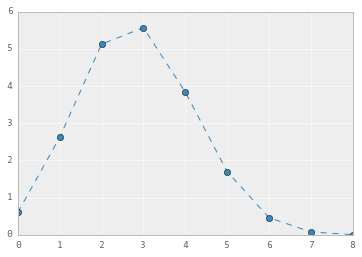

r=-0.6と置いた場合：
q=0.1303475646584853
p(r)=0.1303475646584853


In [14]:
r = -0.60
q = qi(r)

pred_df4 = pd.DataFrame(pd.DataFrame([np.random.binomial(n=8, p=q) for i in range(100000)], columns=['x']).x.value_counts().reset_index())
pred_df4.columns = ['yi', 'num_y']
pred_df4 = pred_df4.sort(columns=['yi'])
plt.plot(pred_df4.yi, [i * 0.0002 for i in pred_df4.num_y], 'o--', label='GLM')
plt.show()

# 分散は3で固定されている
p = pr(r, 3)

print('r={0}と置いた場合：'.format(r))
print('q={0}'.format(p))
print('p(r)={0}'.format(p))

In [15]:
from collections import defaultdict
mixed_y = defaultdict(float)
for i in range(-1000, 1000, 1):
    r = i * 0.1
    q = qi(r)
    p = pr(r, 3)
    pred = pd.Series(np.random.binomial(n=8, p=q) for j in range(1000)).value_counts().to_dict()
    for idx, value in pred.items():
        mixed_y[idx] += 0.02 * value * p
mixed_y

defaultdict(<class 'float'>, {0: 43.223469942031819, 1: 21.306832936488124, 2: 15.46571666357757, 3: 13.822066904045586, 4: 12.799212892568857, 5: 13.44123789132076, 6: 15.62145687496934, 7: 21.373150330796982, 8: 42.946855564200995})

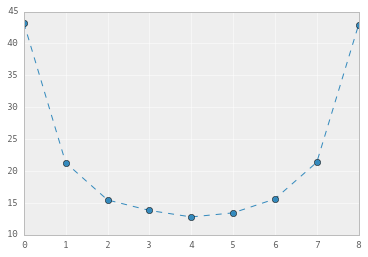

In [16]:
# 二項分布と正規分布の無限混合分布の例
plt.plot(list(mixed_y.keys()), list(mixed_y.values()), 'o--')

### 7.4.1 Rを使ってGLMMのパラメータを推定
Pythonで実装してたやつが間違えていたけど直せなかった・・・無念

## 7.5 現実のデータ解析にはGLMMが必要
GLMMが必要になるかどうかは，「同じ個体・場所などから何度もサンプリングしているか」あるいは「個体差や場所差が識別できてしまうようなデータのとりかたをしているか」に依存する

### 7.5.1 反復・擬似反復と統計モデルの関係

- 各個体でひとつだけ種子の生存を調べている場合
  - 統計モデルに個体差・場所さを入れようがない → GLMMを使えない
  - 個体と植木鉢の両方が反復
- 各植木鉢から一つの個体を選び，各個体から複数の種子を採取
  - 個体のばらつきを考慮したGLMMが使える
- 各植木鉢から複数の個体を選び，各個体から一つの種子を採取
  - 植木鉢のばらつきを考慮したGLMMが使える
- 各植木鉢から複数の個体を選び，各個体から複数の種子を採取
  - GLMMと最尤推定の組合せではなく，階層ベイズモデルとMCMCを使おう

## 7.6 いろいろな分布のGLMM
本を参照